# Build a reduced resolution version of the Boreal Biomass COG mosaic
this reduced res version can be used in ggplot to produce maps for pubs and presentations  
reference:   
https://gist.github.com/wildintellect/  
https://gist.github.com/wildintellect/2efd429da476df46def6af2aa0d1c039  
https://github.com/MAAP-Project/maap-documentation-examples/blob/feat/oviews/visualization/OverviewResampling.ipynb

In [1]:
!conda install mamba
!mamba create -y -n gdal34 -c conda-forge 'gdal>=3.4.3' geopandas ipykernel
!conda activate gdal34
#After this runs switch the kernel of the notebook, may require stopping and closing the notebook

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with initial frozen solve. Retrying with flexible solve.

PackagesNotFoundError: The following packages are not available from current channels:

  - mamba

Current channels:

  - https://repo.anaconda.com/pkgs/main/linux-64
  - https://repo.anaconda.com/pkgs/main/noarch
  - https://repo.anaconda.com/pkgs/r/linux-64
  - https://repo.anaconda.com/pkgs/r/noarch

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at the top of the page.


/bin/bash: mamba: command not found

CommandNotFoundError: Your shell has not been properly configured to use 'conda activate'.
To initialize your shell, run

    $ conda init <SHELL_NAME>

Currently supported shells are:
  - bash
  - fish
  - tcsh
  - xonsh
  - zsh
  - powershell

See 'conda init --help' for more information and options.

IMPORT

In [2]:
import geopandas as gpd
import os
import subprocess

from multiprocessing import Pool
from functools import partial

os.environ['GDAL_DISABLE_READDIR_ON_OPEN'] = 'EMPTY_DIR'

/projects/.local/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


## Get the MosaicJson which has the s3 path to the COGs

In [4]:
# load up the tile_output_index
# dump the s3 column to a txt file (try a small sample)
# generate a VRT from txt file
tile_index_json_fn = "/projects/shared-buckets/nathanmthomas/DPS_tile_lists/07/AGB_tindex_master.json"
tile_index_json_fn = '/projects/shared-buckets/nathanmthomas/DPS_tile_lists/AGB/fall2022/map_boreal_2022_v3/11/AGB_tindex_master.json'
tile_index_json_fn = "/projects/shared-buckets/nathanmthomas/DPS_tile_lists/AGB/winter2023/map_boreal_2022_rh_noground_v4/AGB_tindex_master.json"
tile_index_json_fn = '/projects/shared-buckets/nathanmthomas/DPS_tile_lists/AGB/c2020/map_boreal_2022_rh_noground_v4/AGB_tindex_master.json'
tile_index_json_fn = '/projects/my-public-bucket/analyze_agb/footprints_terrapulse-pub-data_tcc_slope-s3.gpkg'
tiles = gpd.read_file(tile_index_json_fn)
tiles.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   footprint_name  0 non-null      object  
 1   path            649 non-null    object  
 2   file            649 non-null    object  
 3   s3_path         649 non-null    object  
 4   geometry        649 non-null    geometry
dtypes: geometry(1), object(4)
memory usage: 25.5+ KB


## Build the list of COGs needed for the VRT

In [5]:
outdir = os.path.dirname(tile_index_json_fn)
#vrt_list_fn = os.path.join(outdir, "AGB_tindex.txt")
#vrt_fn = os.path.join(outdir, "AGB_tindex.vrt")

vrt_list_fn = os.path.join(outdir, "TCCslope_tindex.txt")
vrt_fn = os.path.join(outdir, "TCCslope_tindex.vrt")

In [6]:
with open(vrt_list_fn, 'w') as f:
    for text in tiles.s3_path.tolist():
        f.write(text.replace("s3:/","/vsis3") + '\n')     

## Build the VRT mosaic needed

In [7]:
#get the bbox as part of the gdalbuildvrt and define it, to save time calculating
boreal_tiles = gpd.read_file('/projects/shared-buckets/nathanmthomas/boreal_tiles_v003.gpkg')
boreal_tiles.crs

tiles.to_crs(boreal_tiles.crs).total_bounds

# time gdalbuildvrt -te -5391478 1323304 5408522 9243304 -input_file_list shared-buckets/alexdevseed/AGB_tindex.txt AGB_tindex.vrt
!time gdalbuildvrt -allow_projection_difference -te -5391478 1323304 5408522 10323304 -input_file_list $vrt_list_fn $vrt_fn

0ERROR 4: `/vsis3/terrapulse-pub-data/boreal-forest-data/tcc_slope/data/005E/60N/005E_60N/005E_60N_tcc_slope.tif' not recognized as a supported file format.
Warning 1: Can't open /vsis3/terrapulse-pub-data/boreal-forest-data/tcc_slope/data/005E/60N/005E_60N/005E_60N_tcc_slope.tif. Skipping it
ERROR 4: `/vsis3/terrapulse-pub-data/boreal-forest-data/tcc_slope/data/008E/60N/008E_60N/008E_60N_tcc_slope.tif' not recognized as a supported file format.
Warning 1: Can't open /vsis3/terrapulse-pub-data/boreal-forest-data/tcc_slope/data/008E/60N/008E_60N/008E_60N_tcc_slope.tif. Skipping it
ERROR 4: `/vsis3/terrapulse-pub-data/boreal-forest-data/tcc_slope/data/008E/62N/008E_62N/008E_62N_tcc_slope.tif' not recognized as a supported file format.
Warning 1: Can't open /vsis3/terrapulse-pub-data/boreal-forest-data/tcc_slope/data/008E/62N/008E_62N/008E_62N_tcc_slope.tif. Skipping it
ERROR 4: `/vsis3/terrapulse-pub-data/boreal-forest-data/tcc_slope/data/008E/65N/008E_65N/008E_65N_tcc_slope.tif' not rec

### Build the function to handle the res reduction

In [9]:
def generate_reduced_res(in_vrt_fn, method, tr=900, outdir=None):
    ''' 
    Build a COG that is a reduced resolution version of the original VRT with overview built with resampling method of choice
    in_vrt_fn = input VRT filename
    method = the resampling method {nearest,bilinear,cubic,cubicspline,lanczos,average,rms,mode}
    tr = target resolution in meters
    return the path to the new reduced resolution COG
    '''
    #make sure the output folder exists
    #os.makedirs(out_dir, exist_ok=True)
    #writing directly to 'bucket' can be slow since it's using s3fuse /tmp is preferred.
    #out_cog_fn = f'/projects/tmp/AGB_tindex_{method}_{str(tr)}m.tif'
    #out_cog_fn = f'{os.path.splitext(in_vrt_fn)[0]}_{method}_{str(tr)}m.tif'
    
    extension = f'_{method}_{str(tr)}m.tif'
    out_basename = os.path.splitext(os.path.basename(in_vrt_fn))[0] + extension
    
    if outdir is None:
        out_cog_fn = f'{os.path.dirname(in_vrt_fn)}/{out_basename}'
    else:
        out_cog_fn = f'{outdir}/{out_basename}'
    
    process = subprocess.run(['gdal_translate', '-of', 'GTiff',
                              '-tr', f'{str(tr)}', f'{str(tr)}',
                              '-r', f'{method}',
                              #'-co', f'OVERVIEW_RESAMPLING={method}',
                              '-co', 'COMPRESS=Deflate',
                              f'{in_vrt_fn}', f'{out_cog_fn}'
                             ], 
                         stdout=subprocess.PIPE, 
                         universal_newlines=True)
    #print(process)
    #print(out_cog_fn)

    return out_cog_fn

In [8]:
# time gdal_translate -of COG -tr 900 900 -co BIGTIFF=IF_NEEDED -co COMPRESS=DEFLATE -co PREDICTOR=2 GDAL_DISABLE_READDIR_ON_OPEN=EMPTY_DIR AGB_tindex.vrt icesat2_boreal_biomass_900m.tif
#!time gdal_translate -of COG -tr 3600 3600 -co BIGTIFF=IF_NEEDED -co COMPRESS=DEFLATE -co PREDICTOR=2 -r {method} -co OVERVIEW_RESAMPLING={method} /projects/my-public-bucket/DPS_tile_lists/07/AGB_tindex.vrt /projects/tmp/AGB_tindex_avg_3600m.tif

# This subetted window works takes 30 minutes
#time gdal_translate -of COG -tr 900 900 -srcwin 0 0 60000 60000 -co BIGTIFF=IF_NEEDED -co COMPRESS=DEFLATE -co PREDICTOR=2 -r average -co OVERVIEW_RESAMPLING=average /projects/my-public-bucket/DPS_tile_lists/07/AGB_tindex.vrt /projects/tmp/AGB_tindex_avg_900m_sub.tif

In [9]:
#generate_reduced_res(vrt_fn, 'average', tr=3600)

## Current working solutions (Feb 2023)

Loop over all the input tiles and reduce each one - in parrallel. This ensures that only 1 file needs to be read at a time and should be more memory efficient. The VRT of the reduced tiles would then be made and converted into a single GTiff or COG with no additional resampling required.

In [10]:
vsi_list = [text.replace("s3:/","/vsis3") for text in tiles.s3_path.tolist()]
vsi_list[0:13]

['/vsis3/terrapulse-pub-data/boreal-forest-data/tcc_slope/data/005E/60N/005E_60N/005E_60N_tcc_slope.tif',
 '/vsis3/terrapulse-pub-data/boreal-forest-data/tcc_slope/data/008E/60N/008E_60N/008E_60N_tcc_slope.tif',
 '/vsis3/terrapulse-pub-data/boreal-forest-data/tcc_slope/data/008E/62N/008E_62N/008E_62N_tcc_slope.tif',
 '/vsis3/terrapulse-pub-data/boreal-forest-data/tcc_slope/data/008E/65N/008E_65N/008E_65N_tcc_slope.tif',
 '/vsis3/terrapulse-pub-data/boreal-forest-data/tcc_slope/data/010E/60N/010E_60N/010E_60N_tcc_slope.tif',
 '/vsis3/terrapulse-pub-data/boreal-forest-data/tcc_slope/data/010E/62N/010E_62N/010E_62N_tcc_slope.tif',
 '/vsis3/terrapulse-pub-data/boreal-forest-data/tcc_slope/data/010E/65N/010E_65N/010E_65N_tcc_slope.tif',
 '/vsis3/terrapulse-pub-data/boreal-forest-data/tcc_slope/data/012E/60N/012E_60N/012E_60N_tcc_slope.tif',
 '/vsis3/terrapulse-pub-data/boreal-forest-data/tcc_slope/data/012E/62N/012E_62N/012E_62N_tcc_slope.tif',
 '/vsis3/terrapulse-pub-data/boreal-forest-dat

In [11]:
#testing 1
# there was a bug in the gdal43 env where AWS permissions failed, switched back to base
#generate_reduced_res(vsi_list[2], 'average', tr=3000)

In [12]:
# with Pool(processes=10) as pool:
#     pool.map(partial(generate_reduced_res, method='average', tr=6000), vsi_list[13:])

## Output dir for the resampled tiles
sometimes you cant write these next to their originals b/c they are in someone else's private bucket

In [11]:
output_location = os.path.dirname(tile_index_json_fn) + '/resample/'
!mkdir -p $output_location
output_location

'/projects/my-public-bucket/analyze_agb/resample/'

## Do individual tile resampling 
##### (Find the missing tiles and fix)

1. Load up the list of files that were produced.
1. Compare against list of inputs, make a list of missing
1. Run the missing tiles through resampler.

In [12]:
resampled = os.listdir(output_location)

resampled_tif = [file for file in resampled if file.endswith('.tif')]
len(resampled_tif)

0

In [13]:
resampled_tilenum = [int(os.path.basename(file).split("_")[3]) for file in resampled_tif]
resampled_tilenum[10:20]

[]

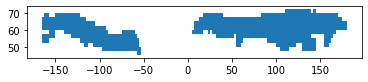

In [17]:
tiles.plot()

In [16]:
#missing = tiles.loc[~tiles['tile_num'].isin(resampled_tilenum)].s3_path.tolist()
missing = tiles.loc[~tiles['file'].isin(resampled_tilenum)].s3_path.tolist()
missing = [text.replace("s3:/","/vsis3") for text in missing]
print(len(missing))
missing[0]

649


'/vsis3/terrapulse-pub-data/boreal-forest-data/tcc_slope/data/005E/60N/005E_60N/005E_60N_tcc_slope.tif'

### Reduce res of individual tiles

In [ ]:
with Pool(processes=10) as pool:
    pool.map(partial(generate_reduced_res, method='nearest', tr=1000, outdir=output_location), missing)
#[generate_reduced_res(fix, 'average', tr=3000, outdir=output_location) for fix in missing]

### Build a VRT of the reduced res individual tiles

In [ ]:
!time gdalbuildvrt -allow_projection_difference -te -5391478 1323304 5408522 10323304 $vrt_fn $output_location/*.tif

### Make a mosaic COG of the reduced res VRT for plotting, mapping, etc

In [ ]:
%%time
generate_reduced_res(vrt_fn, 'average', tr=4500)

In [ ]:
vrt_fn